# Load data

In [9]:
import pandas as pd
import re
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.ticker as mtick

# State Council

      d_t     d_y    d_n
0      国函  2023.0   98.0
1      国函  2023.0   97.0
2      国函  2023.0   87.0
3     国办发  2023.0   27.0
4     国办发  2023.0   29.0
...   ...     ...    ...
5776  国办发  1996.0   17.0
5777  国办发  1998.0    9.0
5778   国发  1996.0   41.0
5779   国函  2023.0  102.0
5780   国函  2023.0  101.0

[5781 rows x 3 columns]
          guofa   guobanfa     guohan  guobanhan
2008  65.789474  29.927007  10.000000   2.941176
2009  54.545455  46.268657  14.814815   6.250000
2010  72.340426  59.677419  17.322835   8.988764
2011  69.565217  68.852459  19.526627  14.201183
2012  68.750000  74.137931  24.137931  29.230769
2013  84.000000  52.678571  15.384615  10.000000
2014  81.428571  75.714286  17.834395  10.937500
2015  86.301370  89.583333  16.814159  11.728395
2016  82.558140  84.761905  28.436019  27.927928
2017  76.785714  82.000000  20.000000  28.676471
2018  88.372093  73.437500  23.602484  18.181818
2019  74.074074  82.456140  12.587413  19.841270
2020  64.705882  88.461538  11.494253 

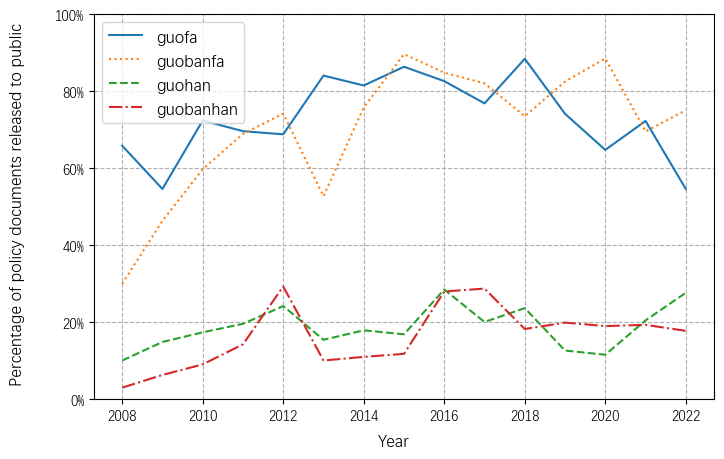

In [10]:
data = pd.read_excel(".//Document number datasets//State Council.xlsx")

plt.style.use("default")
matplotlib.rcParams['font.family'] = ['DengXian']
matplotlib.rcParams['figure.figsize'] = [8, 5]

doc_no_types = []
doc_no_years = []
doc_no_numbers = [] 

def parse_doc_no(doc_no):
    doc_no = str(doc_no).replace(" ", "")

    tokens_to_replace_left = ["(", "[", "（"]
    tokens_to_replace_right = [")", "]", "）"]
    for t in tokens_to_replace_left:
        doc_no = doc_no.replace(t, "〔")
    for t in tokens_to_replace_right:
        doc_no = doc_no.replace(t, "〕")

    if str(doc_no) == "nan":
        return None, None, None 
    else:
        x = re.search("([\u4e00-\u9FFF]{2,8}[〔\[][12][90]\d{2}[〕\]]\d{1,4}号)", doc_no)
        if x:
            doc_no = x.group()
            doc_no_type = doc_no.split("〔")[0]
            doc_no_year = int(doc_no.split("〔")[1].split("〕")[0])
            doc_no_number = doc_no.split("〕")[1]
            if doc_no_number.endswith("号"):
                doc_no_number = doc_no_number[:-1]
            doc_no_number = int(doc_no_number)
            return doc_no_type, doc_no_year, doc_no_number
        else:
            # print any parsing errors
            #print(doc_no)
            return None, None, None

for doc_no in data["document_number_parsed"]:
    d_t, d_y, d_n = parse_doc_no(doc_no)
    doc_no_types.append(d_t)
    doc_no_years.append(d_y)
    doc_no_numbers.append(d_n)

d = {"d_t": doc_no_types, "d_y": doc_no_years, "d_n": doc_no_numbers}
df = pd.DataFrame(d)
print(df)
df["doc_url"] = data["url"]

new_df = pd.DataFrame()

def german_tank_problem(max_value, observations):
    n = max_value + max_value / observations - 1
    n = round(n)
    #print(f"{str(n)} found for {str(max_value)} on {str(observations)} observations")
    return n

# iterate through every unique document type
for t in df["d_t"].unique():
    df_type = df.loc[df["d_t"] == t].reset_index(drop=True)

    # iterate through every unique year
    for y in df_type["d_y"].unique():
        df_type_year = df_type.loc[df_type["d_y"] == y].reset_index(drop=True)

        # generate predicted maximum document numbers
        predicted_n = german_tank_problem(df_type_year["d_n"].max(), len(df_type_year))

        # fill missing values
        def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with="None"):
            return df\
              .merge(how='right', on=field,
                    right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
              .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

        # clean data
        df_type_year = fill_missing_range(df_type_year, "d_n", 1, predicted_n)
        df_type_year["d_t"] = t
        df_type_year["d_y"] = int(y)
        df_type_year["d_n"] = df_type_year["d_n"].astype(int)

        # add to new dataframe
        new_df = pd.concat([new_df, df_type_year]).reset_index(drop=True)

df = pd.DataFrame()
df.index = range(2008, 2023)

for d_t in new_df["d_t"].unique():
    regex = f"国办?[发函]$"
    if re.search(regex, d_t):
        values = []
        for year in range(2008, 2023):
            a = new_df.loc[new_df["d_t"] == d_t].reset_index(drop=True)
            a = a.loc[a["d_y"] == year].reset_index(drop=True)
            try:
                pct = (1-(len(a[a["doc_url"] == "None"]))/len(a))*100
            except ZeroDivisionError:
                pct = 0
            values.append(pct)
        df[d_t] = values

def sortFn(value):
    if value.endswith("发"):
        if "办" in value:
            return 1
        else:
            return 0
    else:
        if "办" in value:
            return 3
        else:
            return 2

labels_ordered = df.columns.tolist()
labels_ordered.sort(key=sortFn)

df = df[labels_ordered]
df.columns = ["guofa", "guobanfa", "guohan", "guobanhan"]
print(df)

linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig, axs = plt.subplots()
fig.supxlabel("Year")
fig.supylabel("Percentage of policy documents released to public")
axs.plot(df)
axs.set_ylim([0, 100])
axs.grid(linestyle="dashed")
axs.yaxis.set_major_formatter(mtick.PercentFormatter())
axs.xaxis.set_major_locator(MaxNLocator(integer=True))
for line, ls in zip(axs.get_lines(), linestyles):
    line.set_linestyle(ls)
axs.legend(loc='upper left', labels=df.columns, fontsize="12")
#print(df.columns)
plt.savefig('Fig_2.png', dpi=600)

# Provincial plots

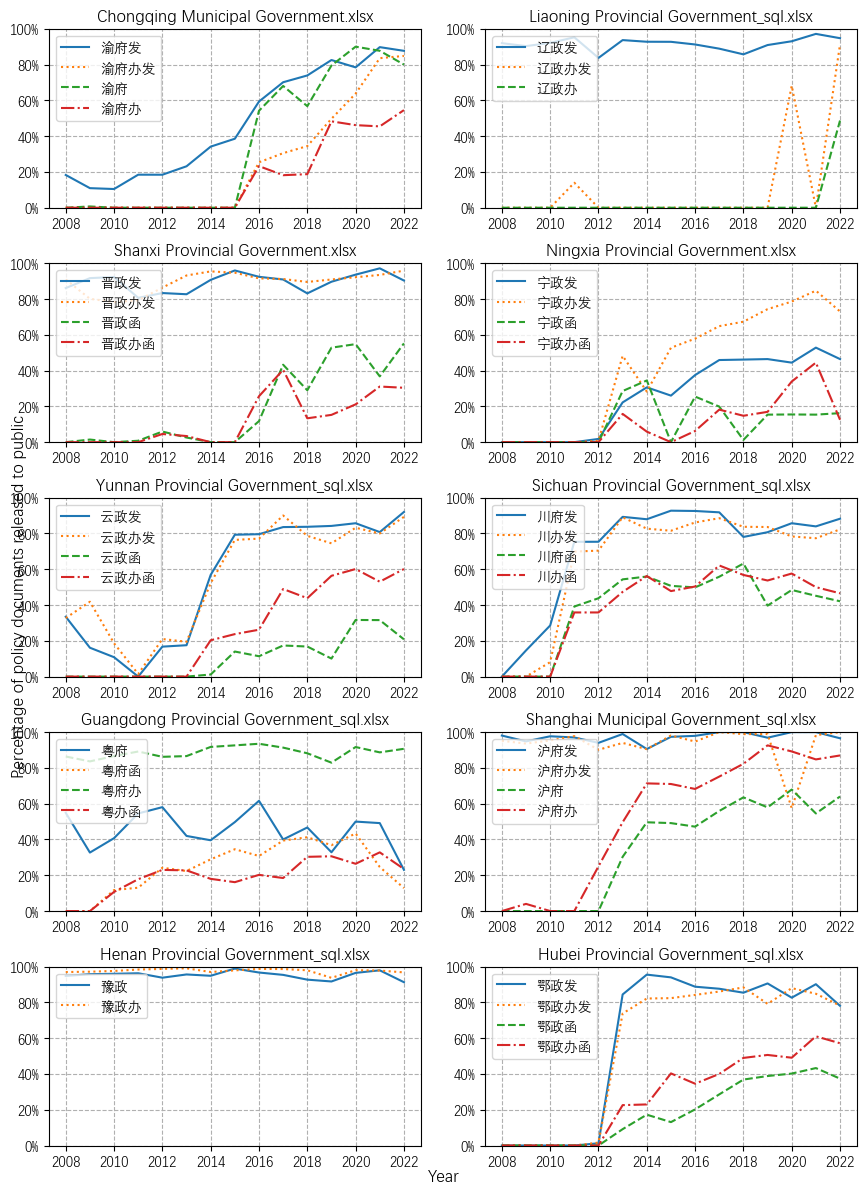

In [11]:

files = ["Chongqing Municipal Government.xlsx", "Liaoning Provincial Government_sql.xlsx",
        "Shanxi Provincial Government.xlsx", "Ningxia Provincial Government.xlsx",
        "Yunnan Provincial Government_sql.xlsx", "Sichuan Provincial Government_sql.xlsx",
        "Guangdong Provincial Government_sql.xlsx", "Shanghai Municipal Government_sql.xlsx",
        "Henan Provincial Government_sql.xlsx", "Hubei Provincial Government_sql.xlsx"]

prov_markers = ["渝", "辽", 
                "晋", "宁", 
                "云", "川", 
                "粤", "沪",
                "豫", "鄂"]

plt.style.use("default")
matplotlib.rcParams['font.family'] = ['DengXian']
matplotlib.rcParams['figure.figsize'] = [9, 12]

num_rows = math.ceil(len(files)/2)

fig, axs = plt.subplots(num_rows, 2)
fig.tight_layout(pad=2.0)

fig.supxlabel("Year")
fig.supylabel("Percentage of policy documents released to public")

for i in range(len(files)):
    file = files[i]
    data = pd.read_excel(".//Document number datasets//" + file)
    
    doc_no_types = []
    doc_no_years = []
    doc_no_numbers = [] 

    def parse_doc_no(doc_no):
        doc_no = str(doc_no).replace(" ", "")
        
        tokens_to_replace_left = ["(", "[", "（"]
        tokens_to_replace_right = [")", "]", "）"]
        for t in tokens_to_replace_left:
            doc_no = doc_no.replace(t, "〔")
        for t in tokens_to_replace_right:
            doc_no = doc_no.replace(t, "〕")
            
        if str(doc_no) == "nan":
            return None, None, None 
        else:
            x = re.search("([\u4e00-\u9FFF]{2,8}[〔\[][12][90]\d{2}[〕\]]\d{1,4}号)", doc_no.strip())
            if x:
                doc_no = x.group()
                doc_no_type = doc_no.split("〔")[0]
                doc_no_year = int(doc_no.split("〔")[1].split("〕")[0])
                doc_no_number = doc_no.split("〕")[1]
                if doc_no_number.endswith("号"):
                    doc_no_number = doc_no_number[:-1]
                doc_no_number = int(doc_no_number)
                return doc_no_type, doc_no_year, doc_no_number
            else:
                # print any parsing errors
                #print(doc_no)
                return None, None, None
    """
    def unify_format(d_t):
        
        unifies document_type formats
        - Changes document numbers with with "府" into "政"
        - Adds "政" if not already present
        
        
        regex = f"^{prov_markers[i]}[政府]?办?[发函]$"
        x = re.search(regex, d_t)
        if x:
            string = x.group()
            string = string.replace("府", "政")
            #print(string[-1])
            #if (string[-1] != "发") and (string[-1] != "函"):
                #string += "发"
            if not any(x in string for x in ["府", "政"]):
                new_string = string[0] + "政" + string[1:]
                #print(f"{d_t} transformed into {new_string}")
                return new_string
            else:
                return string
        else:
            return d_t
    """   
    for doc_no in data["doc_number"]:
        d_t, d_y, d_n = parse_doc_no(doc_no)
        #if d_t:
            #d_t = unify_format(d_t)
        doc_no_types.append(d_t)
        doc_no_years.append(d_y)
        doc_no_numbers.append(d_n)
    cname = "doc_number"
    for doc_no in data[cname]:
        d_t, d_y, d_n = parse_doc_no(doc_no)
        #if d_t:
            #d_t = unify_format(d_t)
        doc_no_types.append(d_t)
        doc_no_years.append(d_y)
        doc_no_numbers.append(d_n)
            
    d = {"d_t": doc_no_types, "d_y": doc_no_years, "d_n": doc_no_numbers}
    df = pd.DataFrame(d)
    df["doc_title"] = "aaa"

    new_df = pd.DataFrame()

    def german_tank_problem(max_value, observations):
        n = max_value + max_value / observations - 1
        n = round(n)
        #print(f"{str(n)} found for {str(max_value)} on {str(observations)} observations")
        return n

    # iterate through every unique document type
    for t in df["d_t"].unique():
        df_type = df.loc[df["d_t"] == t].reset_index(drop=True)

        # iterate through every unique year
        for y in df_type["d_y"].unique():
            df_type_year = df_type.loc[df_type["d_y"] == y].reset_index(drop=True)

            # generate predicted maximum document numbers
            predicted_n = german_tank_problem(df_type_year["d_n"].max(), len(df_type_year))

            # fill missing values
            def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with="None"):
                return df\
                  .merge(how='right', on=field,
                        right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
                  .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

            # clean data
            df_type_year = fill_missing_range(df_type_year, "d_n", 1, predicted_n)
            df_type_year["d_t"] = t
            df_type_year["d_y"] = int(y)
            df_type_year["d_n"] = df_type_year["d_n"].astype(int)

            # add to new dataframe
            new_df = pd.concat([new_df, df_type_year]).reset_index(drop=True)

    df = pd.DataFrame()
    df.index = range(2008, 2023)
    
    for d_t in new_df["d_t"].unique():
        regex = f"^{prov_markers[i]}[政府]?办?[发函]?$"
        if re.search(regex, d_t):
            values = []
            for year in range(2008, 2023):
                a = new_df.loc[new_df["d_t"] == d_t].reset_index(drop=True)
                
                # Only plot entries for which we have > n documents
                if len(a[a["doc_title"] != "None"]) > 25:
                    save = True
                else:
                    save = False
                    
                a = a.loc[a["d_y"] == year].reset_index(drop=True)
                try:
                    pct = (1-(len(a[a["doc_title"] == "None"]))/len(a))*100
                except ZeroDivisionError:
                    pct = 0
                values.append(pct)
            
            if save:
                df[d_t] = values
    
    if i % 2 == 0:
        column_no = 0
    else:
        column_no = 1
        
    row_no = math.floor(i/2)
    
    def sortFn(value):
        if value.endswith("发"):
            if "办" in value:
                return 1
            else:
                return 0
        else:
            if "办" in value:
                return 3
            else:
                return 2

    labels_ordered = df.columns.tolist()
    labels_ordered.sort(key=sortFn)

    df = df[labels_ordered]
    
    axs[row_no, column_no].plot(df)
    linestyles=['solid', 'dotted', 'dashed', 'dashdot']
    for line, ls in zip(axs[row_no, column_no].get_lines(), linestyles):
        line.set_linestyle(ls)
    axs[row_no, column_no].set_title(file)
    axs[row_no, column_no].legend(loc='upper left', labels=df.columns)
    axs[row_no, column_no].set_ylim([0, 100])
    axs[row_no, column_no].grid(linestyle="dashed")
    axs[row_no, column_no].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[row_no, column_no].xaxis.set_major_locator(MaxNLocator(integer=True))
    #print(df.columns)
plt.savefig('Fig_3.png', dpi=600)